# Pocket-level evaluation for P2Rank
Replicate the approach from `./pocket-level-evaluation.ipynb` on the CryptoBench test set, however, on the results from P2Rank.

In [1]:
import csv
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('/home/vit/Projects/cryptoshow-analysis/src')
import cryptoshow_utils

P2RANK_PREDICTIONS_PATH = '/home/vit/Projects/cryptobench/data/H-prediction-evaluation/ahoj-v2/p2rank/p2rank-predictions/predict_single-pair-test_apo'

def read_predicted_pockets_p2rank(protein_ids) -> dict[str, list[set[int]]]:
    '''Reads predicted pockets from P2Rank output files.
    Args:
        protein_ids: List of protein IDs in the format PDB-ID_CHAIN-ID (e.g. 1abc_A)
    Returns:
        predicted_pockets: A dictionary mapping protein IDs to a list of predicted pockets,
        where each pocket is represented as a set of residue indices (integers).
        sequences: A dictionary mapping protein IDs to their corresponding sequences.
    '''
    predicted_pockets = {}
    sequences = {}

    for protein_id in protein_ids:
        pdb_id, chain_id = protein_id.split('_')
        filename = f'{P2RANK_PREDICTIONS_PATH}/{pdb_id.lower()}.cif_predictions.csv'
        with open(filename, 'r') as f:
            reader = csv.reader(f, delimiter=',')
            next(reader)  # skip header
            data = list(reader)
            row_count = len(data)

            pockets = []

            if row_count == 0:
                predicted_pockets[protein_id] = pockets
                _, sequence = cryptoshow_utils.map_residues_to_mmcif(pdb_id, chain_id, [])
                sequences[protein_id] = sequence
                continue

            for row in data:
                residue_indices = row[9].strip().split(' ')

                # check that they have correct chain id and add collect them
                pocket_residues = set()
                for res_idx in residue_indices:
                    this_chain_id, res_num = res_idx.split('_')
                    if this_chain_id != chain_id:
                        continue
                    pocket_residues.add(res_num)
                
                pocket_residues, sequence = cryptoshow_utils.map_residues_to_mmcif(pdb_id, chain_id, pocket_residues)
                pockets.append(pocket_residues)
                sequences[protein_id] = sequence
            predicted_pockets[protein_id] = pockets

    return predicted_pockets, sequences

## Test on CRYPTIC pockets
Take only the CRYPTIC pockets and check P2Rank performance.

In [3]:
# load CB test set and P2Rank predictions
from eval_utils import read_test_binding_residues
cryptic_binding_residues, ground_truth_sequences = read_test_binding_residues(data_path='/home/vit/Projects/cryptoshow-analysis/data/A-cluster-ligysis-data/clustered-binding-sites.txt', pocket_types=['CRYPTIC'])
predicted_pockets, sequences = read_predicted_pockets_p2rank(cryptic_binding_residues.keys())

# check that sequences match (the ground-truth sequences taken from the src/A-cluster-ligysis-data/main.ipynb and the sequences extracted from the mmCIF files when reading the P2Rank predictions)
for key in cryptic_binding_residues.keys():
    assert ground_truth_sequences[key] == sequences[key], f"Sequences do not match for {key}!"

In [ ]:
# to combine p2rank-predicted and model-predicted pockets, save the predicted pockets to a file
import pickle

out_path = '/home/vit/Projects/cryptoshow-analysis/data/B-evaluate-cryptoshow/predicted_pockets_p2rank.pkl'
with open(out_path, 'wb') as f:
    pickle.dump(predicted_pockets, f, protocol=pickle.HIGHEST_PROTOCOL)

## Compute metrics and plot
Compute DCC, coverage, dice coefficient and plot histograms.

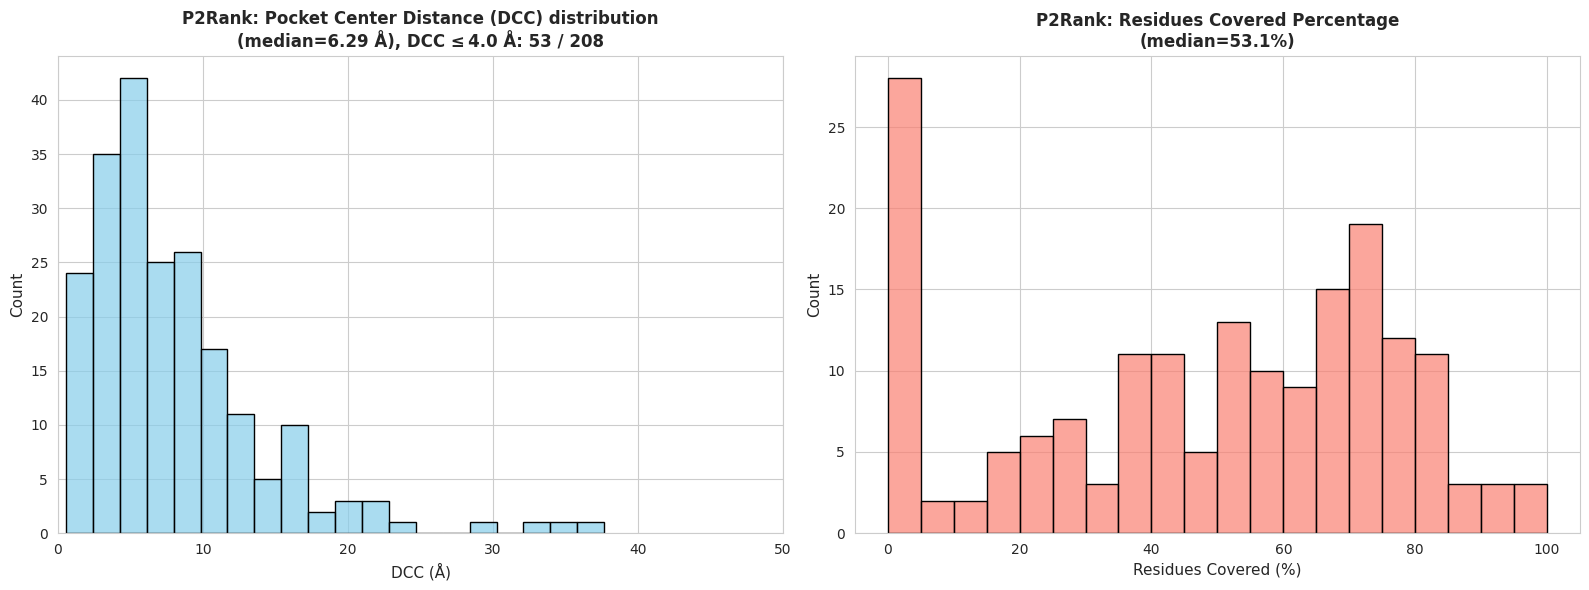

/home/vit/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vit/.local/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


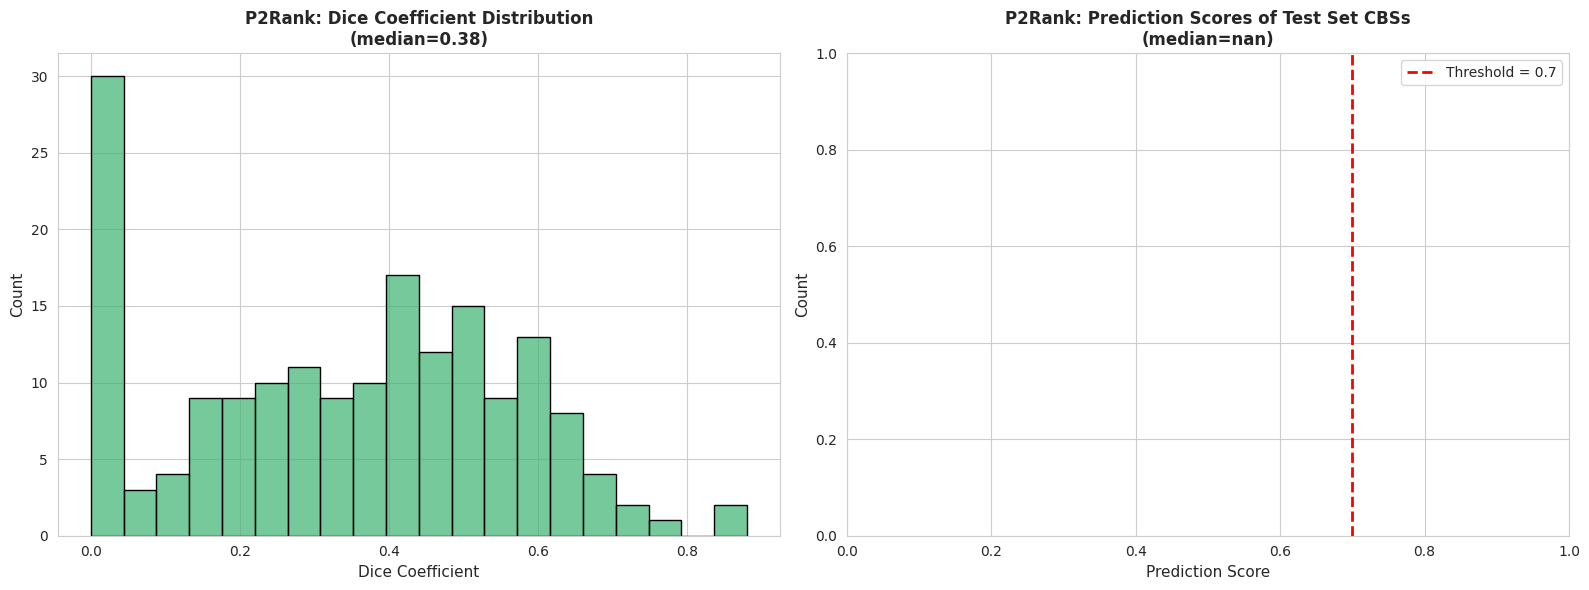

In [4]:
import os

DCC_THRESHOLD = 4.0  # in Angstroms
MODEL = 'P2Rank'
COORDINATES_DIR = '/home/vit/Projects/cryptoshow-analysis/data/A-cluster-ligysis-data/coordinates'

def print_plots():
    DCCs = []
    coverages = []
    dice_coefficients = []
    binding_prediction_scores = []
    
    for protein_id in cryptic_binding_residues.keys():
        if len(predicted_pockets[protein_id]) == 0 or len(cryptic_binding_residues[protein_id]) == 0:
            continue
        coordinates = np.load(f'{COORDINATES_DIR}/{protein_id.replace("_", "")}.npy')
    
        # loop over each cryptic binding site
        for actual_cryptic_binding_residue_indices in cryptic_binding_residues[protein_id]:
            dcc = float('inf')
            actual_cryptic_binding_residue_indices = [int(i.split('_')[1]) for i in actual_cryptic_binding_residue_indices]
    
            # loop over each predicted binding site and select the one with the lowest DCC
            for predicted_cryptic_binding_residue_indices in predicted_pockets[protein_id]:
                predicted_cryptic_binding_residue_indices = [int(i[1:]) for i in predicted_cryptic_binding_residue_indices]
                dcc = min(dcc, cryptoshow_utils.compute_center_distance(coordinates, actual_cryptic_binding_residue_indices, predicted_cryptic_binding_residue_indices))
            
            DCCs.append(dcc)
        
        concatenated_cryptic_binding_residues = np.unique(np.concatenate(cryptic_binding_residues[protein_id]))
        concatenated_cryptic_binding_residues = [int(i.split('_')[1]) for i in concatenated_cryptic_binding_residues]
        concatenated_predicted_binding_residues = np.unique(np.concatenate([[int(ii[1:]) for ii in i] for i in predicted_pockets[protein_id]]))
        residues_covered = np.intersect1d(np.array(concatenated_cryptic_binding_residues), concatenated_predicted_binding_residues)
    
        this_coverage = len(residues_covered) / len(concatenated_cryptic_binding_residues) * 100
        this_dice_coefficient = 2 * len(residues_covered) / (len(concatenated_cryptic_binding_residues) + len(concatenated_predicted_binding_residues)) if (len(concatenated_cryptic_binding_residues) + len(concatenated_predicted_binding_residues)) > 0 else 0
        
        coverages.append(this_coverage)
        dice_coefficients.append(this_dice_coefficient)

    sns.set_style("whitegrid")
    plt.rcParams['figure.facecolor'] = 'white'
    os.makedirs('fig', exist_ok=True)

    _, axs = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(DCCs, bins=20, color='skyblue', edgecolor='black', alpha=0.7, ax=axs[0])
    axs[0].set_title(f'{MODEL}: Pocket Center Distance (DCC) distribution\n(median={np.median(DCCs):.2f} Å), DCC ≤ {DCC_THRESHOLD} Å: {np.sum(np.array(DCCs) < DCC_THRESHOLD)} / {len(DCCs)}', fontsize=12, fontweight='bold')
    axs[0].set_xlabel('DCC (Å)', fontsize=11)
    axs[0].set_ylabel('Count', fontsize=11)
    axs[0].set_xlim(0, 50)

    sns.histplot(coverages, bins=20, color='salmon', edgecolor='black', alpha=0.7, ax=axs[1])
    axs[1].set_title(f'{MODEL}: Residues Covered Percentage\n(median={np.median(coverages):.1f}%)', fontsize=12, fontweight='bold')
    axs[1].set_xlabel('Residues Covered (%)', fontsize=11)
    axs[1].set_ylabel('Count', fontsize=11)

    plt.tight_layout()
    plt.show()

    _, axs = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(dice_coefficients, bins=20, color='mediumseagreen', edgecolor='black', alpha=0.7, ax=axs[0])
    axs[0].set_title(f'{MODEL}: Dice Coefficient Distribution\n(median={np.median(dice_coefficients):.2f})', fontsize=12, fontweight='bold')
    axs[0].set_xlabel('Dice Coefficient', fontsize=11)
    axs[0].set_ylabel('Count', fontsize=11)

    sns.histplot(binding_prediction_scores, bins=20, color='gold', edgecolor='black', alpha=0.7, ax=axs[1])
    axs[1].axvline(0.7, color='red', linestyle='--', linewidth=2, label='Threshold = 0.7')
    axs[1].set_title(f'{MODEL}: Prediction Scores of Test Set CBSs\n(median={np.median(binding_prediction_scores):.2f})', fontsize=12, fontweight='bold')
    axs[1].set_xlabel('Prediction Score', fontsize=11)
    axs[1].set_ylabel('Count', fontsize=11)
    axs[1].legend(fontsize=10)

    plt.tight_layout()
    plt.show()

print_plots()

## Test on NON-CRYPTIC pockets
Take only the NON-CRYPTIC pockets and check P2Rank performance.

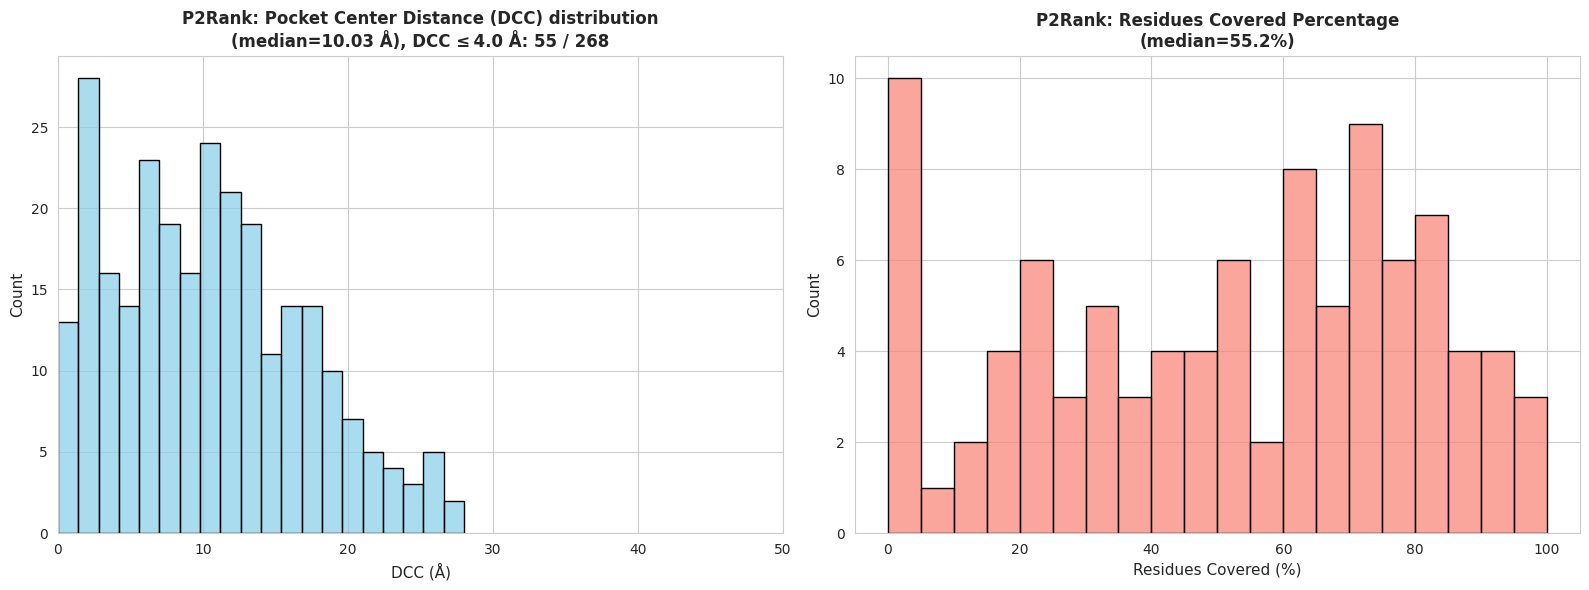

/home/vit/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vit/.local/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


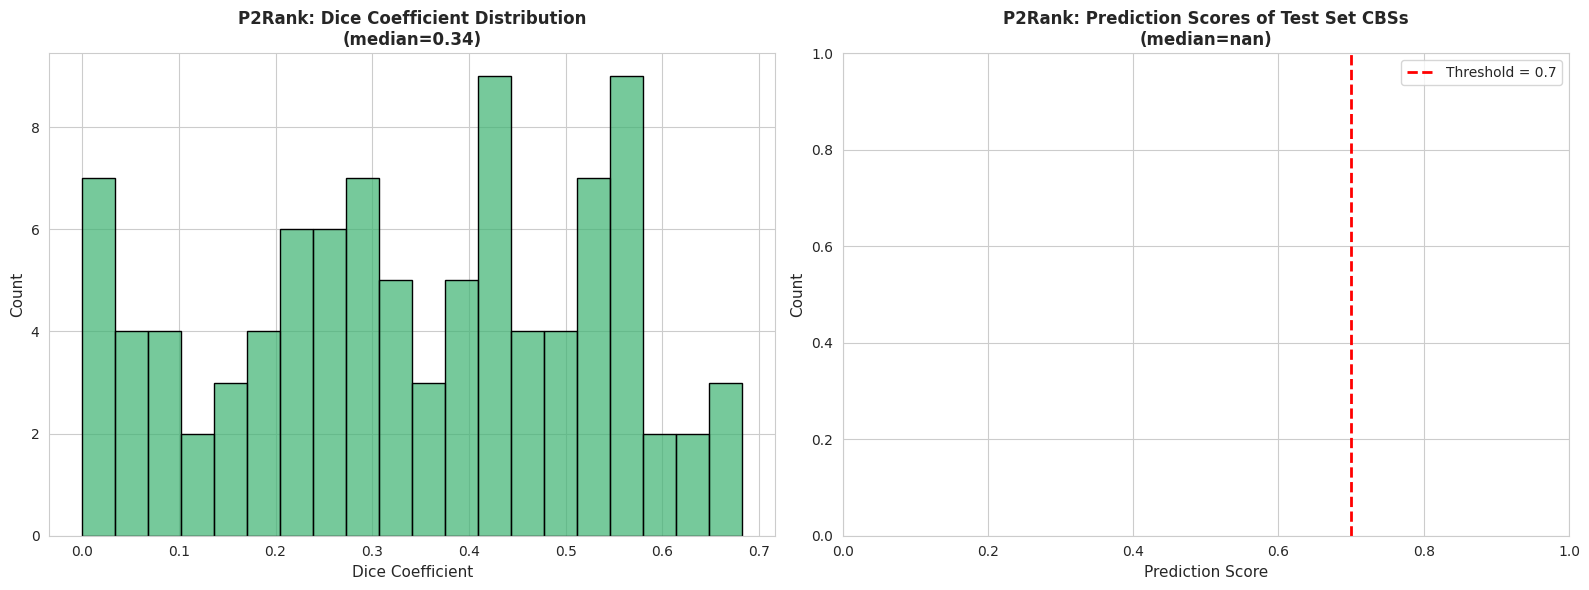

In [ ]:
cryptic_binding_residues, ground_truth_sequences = read_test_binding_residues(data_path='/home/vit/Projects/cryptoshow-analysis/data/A-cluster-ligysis-data/clustered-binding-sites.txt', pocket_types=['NON_CRYPTIC'])
print_plots()

## Test on NON-CRYPTIC AND CRYPTIC pockets
Take both CRYPTIC and NON-CRYPTIC pockets and check P2Rank performance.

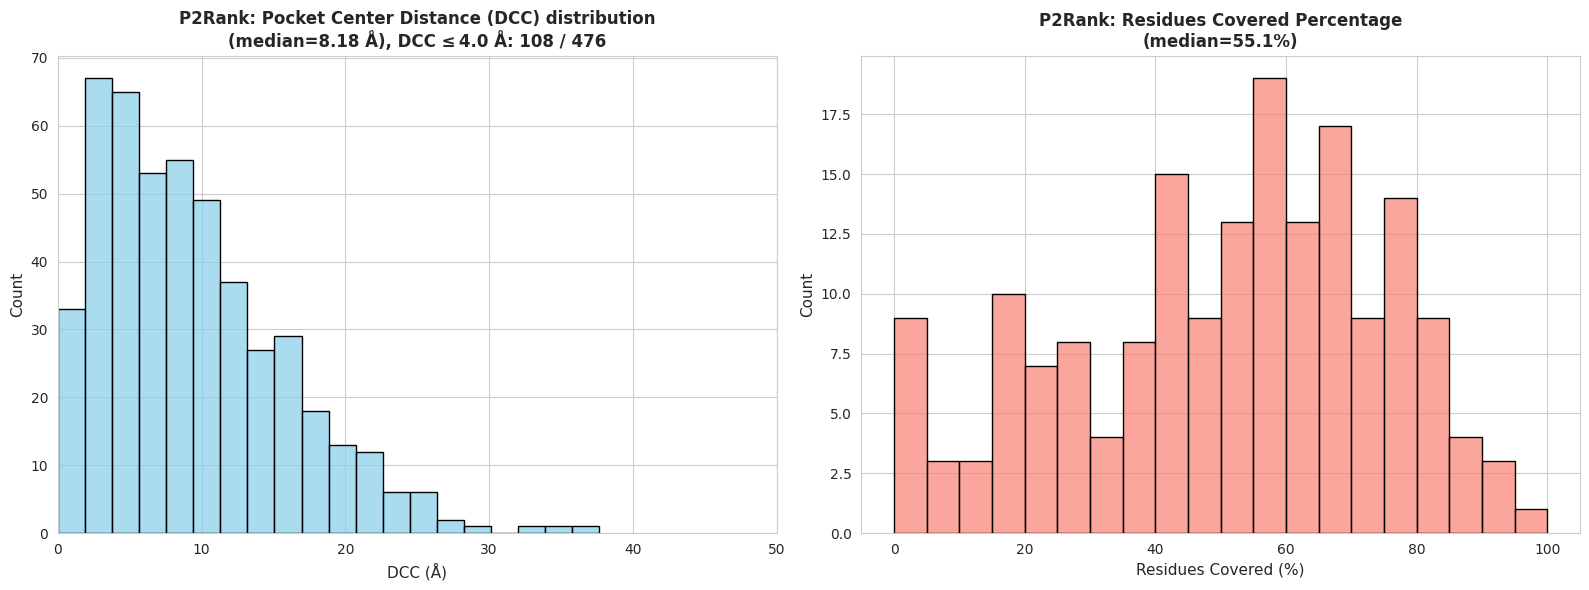

/home/vit/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vit/.local/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


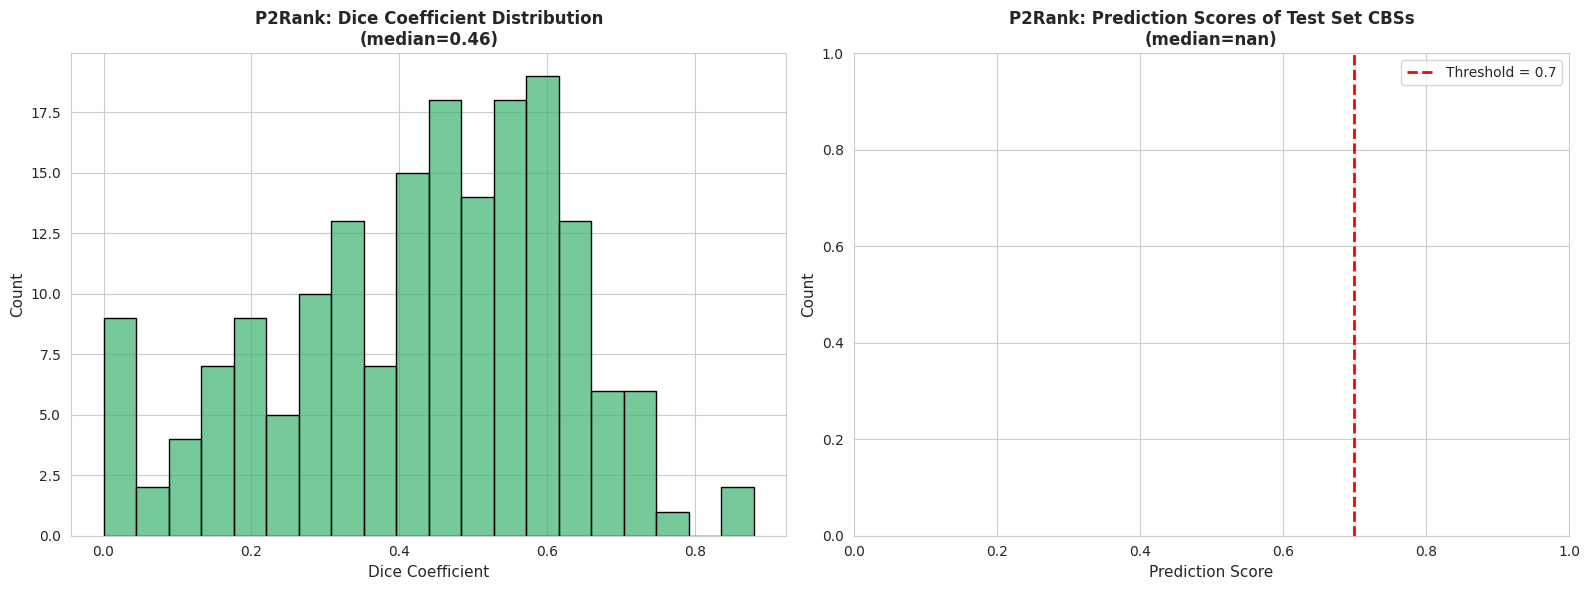

In [ ]:
cryptic_binding_residues, ground_truth_sequences = read_test_binding_residues(data_path='/home/vit/Projects/cryptoshow-analysis/data/A-cluster-ligysis-data/clustered-binding-sites.txt', pocket_types=['CRYPTIC', 'NON_CRYPTIC'])
print_plots()